In [9]:
import sys
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [10]:
import PowerSpec as ps
import Plot_PowerSpec as pp

# 1- 10°x10° boxes for the North Atlantic basin 

## Definition of the boxes

In [11]:
gridfile = '/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001_mesh_mask_surf.nc'
ncfile = xr.open_dataset(gridfile)

In [12]:


# - Define read data function
def read_datagrid(gridfile,latmin=None,latmax=None,lonmin=None,lonmax=None):
    """Return navlon,navlat."""
    ncfile = xr.open_dataset(gridfile)
    # load navlon and navlat
    _navlon = ncfile['glamt'][0,:,:]
    _navlat = ncfile['gphit'][0,:,:]
    #-Define domain
    domain = (lonmin<_navlon) * (_navlon<lonmax) * (latmin<_navlat) * (_navlat<latmax)
    where = np.where(domain)
    #get indice
    jmin = np.min(where[0][:])
    jmax = np.max(where[0][:])
    imin = np.min(where[1][:])
    imax = np.max(where[1][:])
    #load arrays
    navlon = _navlon[jmin:jmax+1,imin:imax+1]
    navlat = _navlat[jmin:jmax+1,imin:imax+1]
    return navlon,navlat,jmin,jmax,imin,imax

# - Define box dimensions
Box_01 = ['40.0','30.0','-70.0','-60.0','Box_1']
Box_02 = ['40.0','30.0','-60.0','-50.0','Box_2']
Box_03 = ['40.0','30.0','-50.0','-40.0','Box_3']

# - Generate box array
box_arr = []
for ii in np.arange(1,4,1):
    name = eval('Box_'+str(ii).zfill(2))
    box_arr.append(name)

#- defining dictionaries for the boxes
class box: # empty container.
    def __init__(self,name=None):
        self.name = name
        return

dictboxes = {}

for ibox in box_arr:
    
    y2 = eval(ibox[0]) ;y1 = eval(ibox[1]);
    x2 = eval(ibox[2]) ;x1 = eval(ibox[3]);
    box_name = ibox[4]

    # - Obtain navlon and Navlat
    navlon,navlat,jmin,jmax,imin,imax = read_datagrid(gridfile,latmin=y1,latmax=y2,lonmin=x2,lonmax=x1)

    # - save box parameter
    abox = box(box_name)
    abox.lonmin = navlon.min()
    abox.lonmax = navlon.max()
    abox.latmin = navlat.min()
    abox.latmax = navlat.max()
    abox.navlon = navlon.values
    abox.navlat = navlat.values
    abox.imin = imin
    abox.imax = imax
    abox.jmin = jmin
    abox.jmax = jmax
    dictboxes[box_name] = abox

boxes = dictboxes.values()

In [13]:
for box in boxes:
    print(box.imin,box.imax,box.jmin,box.jmax)

(576, 695, 613, 760)
(456, 576, 613, 763)
(336, 456, 614, 766)


## Map of the boxes

# 2- Wavenumber Spectrum for U and V

In [14]:
# Datasets of daily surface meridional and zonal velocities

fileu = sorted(glob.glob("/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m??.1d_gridUsurf.nc"))
filev = sorted(glob.glob("/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m??.1d_gridVsurf.nc"))




In [15]:
# Some functions that allow us to compute spectra in boxes

##########################################
def get_values_in_box(box,data):
    jmin,jmax = box.jmin,box.jmax
    imin,imax = box.imin,box.imax
    values = data[:,0,jmin:jmax+1,imin:imax+1].values
    values = ma.masked_invalid(values)
    return values

##########################################
def compute_spec_in_boxes(boxes,data,Mth):
    for box in boxes:
        #print('processing box ' +  box.name)
        compute_spec_for_box(box,data,Mth)

##########################################
def compute_spec_for_box(box,data,Mth):
    var = get_values_in_box(box,data)
    kspec,pspec = compute_spec(var,box.navlon,box.navlat)
    np.savez(WaveSpecResult+'WaveSpec_'+box.name+'_'+param+'_'+Mth, kspec=kspec ,pspec=pspec)

##########################################
def compute_spec(data,navlon,navlat):
    days = len(data)
    mth_pspec = []
    for it in np.arange(0,days):
        arr = data[it]
        x_reg,y_reg,data_reg = ps.interpolate(arr,navlon,navlat,interp='basemap')
        data_reg = ps.isdata_contain_nan(data_reg)
        kspec,pspec = ps.get_spectrum(data_reg,x_reg,y_reg,window='Tukey',detrend='Both')
        mth_pspec.append(pspec)
    mthly_pspec = np.array(mth_pspec)
    mean_mthly_pspec = mthly_pspec.mean(axis=0)
    return kspec,mean_mthly_pspec

In [16]:
# Implementation for surface zonal velocities U

param='Uspec'
varname = 'vozocrtx'
filenames = fileu
WaveSpecResult = '/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/'+param+'/'
YrMth  = ['2012_01','2012_02','2012_03','2012_04','2012_05','2012_06','2012_07','2012_08','2012_09','2012_10','2012_11','2012_12']

ii= 0
for filename in filenames:
    print(filename)
    ncfile = xr.open_dataset(filename)
    data = ncfile.variables[varname]
    Mth = YrMth[ii]
    compute_spec_in_boxes(boxes,data,Mth)
    ii=ii + 1


/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m01.1d_gridUsurf.nc
('days =', 31)
('days =', 31)
('days =', 31)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m02.1d_gridUsurf.nc
('days =', 28)
('days =', 28)
('days =', 28)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m03.1d_gridUsurf.nc
('days =', 31)
('days =', 31)
('days =', 31)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m04.1d_gridUsurf.nc
('days =', 30)
('days =', 30)
('days =', 30)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m05.1d_gridUsurf.nc
('days =', 31)
('days =', 31)
('days =', 31)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m06.1d_gridUsurf.nc
('days =', 30)
('days =', 30)
('days =', 30)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS

In [17]:
# Implementation for surface meridional velocities V

param='Vspec'
varname = 'vomecrty'
filenames = filev
WaveSpecResult = '/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/'+param+'/'
YrMth  = ['2012_01','2012_02','2012_03','2012_04','2012_05','2012_06','2012_07','2012_08','2012_09','2012_10','2012_11','2012_12']

ii= 0
for filename in filenames:
    print(filename)
    ncfile = xr.open_dataset(filename)
    data = ncfile.variables[varname]
    Mth = YrMth[ii]
    compute_spec_in_boxes(boxes,data,Mth)
    ii=ii + 1


/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m01.1d_gridVsurf.nc
('days =', 31)
('days =', 31)
('days =', 31)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m02.1d_gridVsurf.nc
('days =', 28)
('days =', 28)
('days =', 28)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m03.1d_gridVsurf.nc
('days =', 31)
('days =', 31)
('days =', 31)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m04.1d_gridVsurf.nc
('days =', 30)
('days =', 30)
('days =', 30)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m05.1d_gridVsurf.nc
('days =', 31)
('days =', 31)
('days =', 31)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS12.L75-MAA4001_y2010m06.1d_gridVsurf.nc
('days =', 30)
('days =', 30)
('days =', 30)
/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/NACHOS

# 3 - Eddy Kinetic Energy Wavenumber Spectra from U & V Wavenumber Spectra

In [18]:
# Folders containing U and V spectral
u_database = '/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/Uspec/'
v_database = '/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/Vspec/'

In [19]:
# Folders to contain computed KE spectral
KEspecFolder = '/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/KEspec/'

In [20]:
# Compute KE spectral then save to file
for box in boxes:
    print box.name
    u_filenames = sorted(glob.glob(u_database + 'WaveSpec_'+box.name+'_Uspec_*.npz'))
    v_filenames = sorted(glob.glob(v_database + 'WaveSpec_'+box.name+'_Vspec_*.npz'))
    for i in range(len(u_filenames)):
        uspec = np.load(u_filenames[i])['pspec']
        vspec = np.load(v_filenames[i])['pspec']
        kspec = np.load(u_filenames[i])['kspec']
        KEspec = 0.5*(uspec + vspec)
        np.savez(KEspecFolder+'WaveSpec_'+box.name+'_KEspec_'+YrMth[i]+'.npz',kspec = kspec,KEspec = KEspec)

Box_3
Box_2
Box_1


# 4 - Comparative Plots of Eddy Kinetic Energy Wavenumber Spectra in boxes

## Steps 1-2-3 have also been implemented for NATL60 outputs and the resulting spectra have been stored in N60_database.

In [24]:
# Folders containing the spectra in boxes for Eddy Kinetic Energy

N12_database = '/Users/auraoupa/Data/NACHOS12.L75/NACHOS12.L75-MAA4001-S/u_v_1d/'
N60_database = '/Users/auraoupa/Data/NATL60/NATL60-CJM165-S/'

In [25]:
# Some functions to make the plots

def mean_pspec(filenames,i,j):
    ''' Compute mean spectrum'''
    _pspec = []
    for filename in filenames:
        spec = np.load(filename)
        kspec = spec['kspec'];
        pspec = spec['KEspec'];
        _pspec.append(pspec) 
    pspec_ar = np.array(_pspec)
    mean_pspec = pspec_ar[i:j].mean(axis=0)
    return kspec,mean_pspec

def comp_slope(database,i,j):
    ''' Compute slope of avearged spectrum'''
    slope_10_100 = []
    slope_70_250 = []
    for box in boxes:
        filenames = sorted(glob.glob(database + 'KEspec/WaveSpec_'+box.name+'_KEspec_*.npz'))
        kpsec,pspec = mean_pspec(filenames,i,j)
        m1 = pp.get_slope(kpsec,pspec,10*1E3,100*1E3)
        m2 = pp.get_slope(kpsec,pspec,70*1E3,250*1E3)
        slope_10_100.append(m1)
        slope_70_250.append(m2)
    slope_10_100_arr = np.array(slope_10_100)
    slope_70_250_arr = np.array(slope_70_250)
    return slope_10_100_arr,slope_70_250_arr

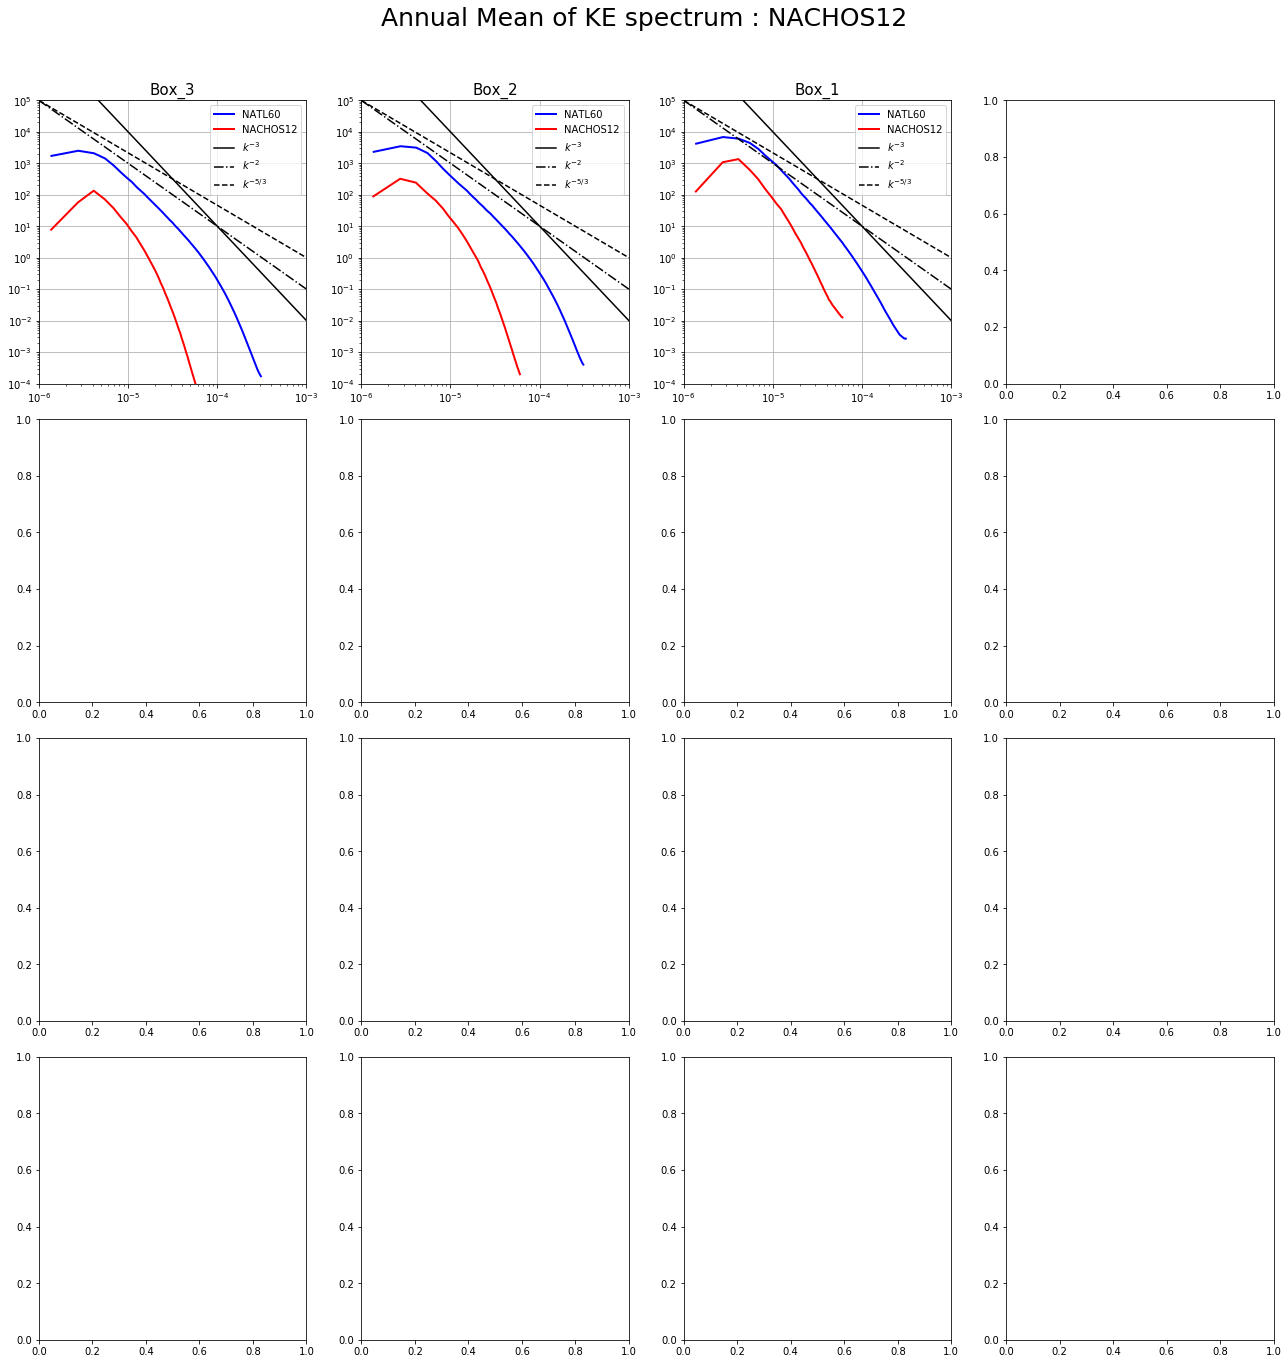

In [26]:
# Final Plots

fig, axs = plt.subplots(4,4, figsize=(18, 18))
axs = axs.ravel()
title = 'Annual Mean of KE spectrum : NACHOS12'
plt.suptitle(title,size = 25,y=1.05)

# - general slope
k = np.array([1E-6,1E-3])
s3 = k**-3/1.e11
s2 = k**-2/1.e7
s53 = k**(-5./3.)/1.e5

i = 0
for box in boxes:
    N12_filenames = sorted(glob.glob(N12_database + 'KEspec/WaveSpec_'+box.name+'_KEspec_*.npz'))
    N12_kpsec,N12_pspec = mean_pspec(N12_filenames,0,12)
    N60_filenames = sorted(glob.glob(N60_database + 'KEspec/WaveSpec_'+box.name+'_KEspec_*.npz'))
    N60_kpsec,N60_pspec = mean_pspec(N60_filenames,0,12)
    axs[i].loglog(N60_kpsec,N60_pspec,'b',linewidth=2.0,label='NATL60')
    axs[i].loglog(N12_kpsec,N12_pspec,'r',linewidth=2.0,label='NACHOS12')
    axs[i].loglog(k,s3,'k-',label=r'$k^{-3}$')
    axs[i].loglog(k,s2,'k-.',label=r'$k^{-2}$')
    axs[i].loglog(k,s53,'k--',label=r'$k^{-5/3}$')
    axs[i].set_xlim(1E-6,1E-3)
    axs[i].set_ylim(1E-4,1E5)
    axs[i].set_title(box.name,size=15)
    axs[i].legend()
    axs[i].grid(True)
    i = i + 1
    fig.tight_layout()